# Estimation of tree height using GEDI dataset - Perceptron complete - 2024

    cd /media/sf_LVM_shared/my_SE_data/exercise/
    wget https://raw.githubusercontent.com/selvaje/SE_docs/master/source/CASESTUDY/Tree_Height_05Perceptron_intro2_2024.ipynb 
    source $HOME/venv/bin/activate
    pip3 install pytorch torchvision torchaudi

In [1]:
# Ref: https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

'''
Packages

conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
conda install -c anaconda scikit-learn
conda install pandas
'''

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predictors = pd.read_csv("./tree_height_2/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


In [3]:
predictors_sel = predictors.loc[(predictors['h'] < 7000)  ].sample(100000)
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 ) # add a culumn of heigh in meter
len(predictors_sel)
predictors_sel.head(10)

,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
1153879,1153880,9.483462,49.539732,2698.50,26.9850,1521,12,2211,6456,-38.769566,-171329872,0.909725,0.017284,387.760681,24,313.061279,123.028320,143.453125,0.001974,9,744561,19.153490,477.286377,85
100193,100194,6.402990,48.160826,2840.00,28.4000,1490,15,2813,6103,9.429293,-239497888,-0.138371,0.113774,413.604126,20,177.321289,67.494141,-187.288818,-0.102324,17,983700,20.812202,451.391693,91
971450,971451,9.026851,49.697633,889.25,8.8925,1503,14,2191,6328,-44.896809,-189144608,1.382000,-0.013207,409.292603,21,132.182129,120.113281,156.145996,-0.025869,9,721059,19.521637,461.523285,85
1066925,1066926,9.258826,49.720251,2913.75,29.1375,1523,13,1909,6660,-12.994958,-221393680,-0.969103,0.103770,234.878723,20,-147.236816,-99.658691,-194.407227,-0.181317,13,711526,19.250071,499.401642,78
1053465,1053466,9.224782,49.508860,3022.25,30.2225,1501,11,2457,6360,-20.087774,-168334016,1.903988,0.009734,460.514221,24,215.913330,104.658447,13.859375,0.010591,15,766824,19.535316,454.539856,86
154462,154463,6.610392,48.251760,3203.75,32.0375,1519,17,2505,6282,-32.618103,-131224912,0.786824,0.001271,348.446075,21,718.891602,522.485107,322.403076,0.002080,9,987009,21.068962,524.362488,97
294748,294749,6.973895,49.938911,2141.50,21.4150,1523,15,1901,6286,2.048864,-181843936,-1.396497,-0.066015,212.771896,21,-294.221680,-131.095703,-367.163330,-0.145465,24,619360,20.109730,476.053925,85
686708,686709,8.009574,48.882388,2677.75,26.7775,1527,12,2331,6544,-26.893196,-28506266,-1.346059,0.005692,132.664291,26,467.995605,175.872314,232.802246,-0.012571,19,757812,19.207001,499.380981,100
117300,117301,6.469159,48.485289,2901.50,29.0150,1544,13,2104,6199,-39.694275,-142835504,0.311964,-0.000897,266.306885,25,643.229736,79.876953,251.753418,-0.034514,12,909120,19.335592,467.628601,97
1219703,1219704,9.724066,49.454074,2998.00,29.9800,1534,15,2145,6522,-22.416445,-260764176,0.310734,0.105692,355.304596,15,488.755371,324.404785,530.772705,-0.078254,8,800737,18.754236,499.480255,96


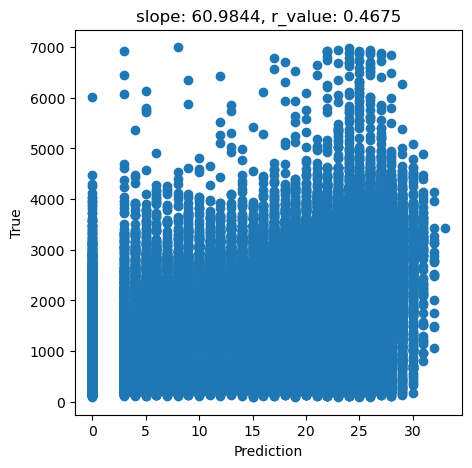

In [4]:
# What we are trying to beat
y_true = predictors_sel['h']
y_pred = predictors_sel['forestheight']

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_true)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_true)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()


In [5]:
tree_height = predictors_sel['hm'].to_numpy()
data = predictors_sel.drop(columns=['ID','h', 'hm','forestheight'], axis=1)

data.shape[1]: 20, n_plots_x: 5,n_plots_y: 4


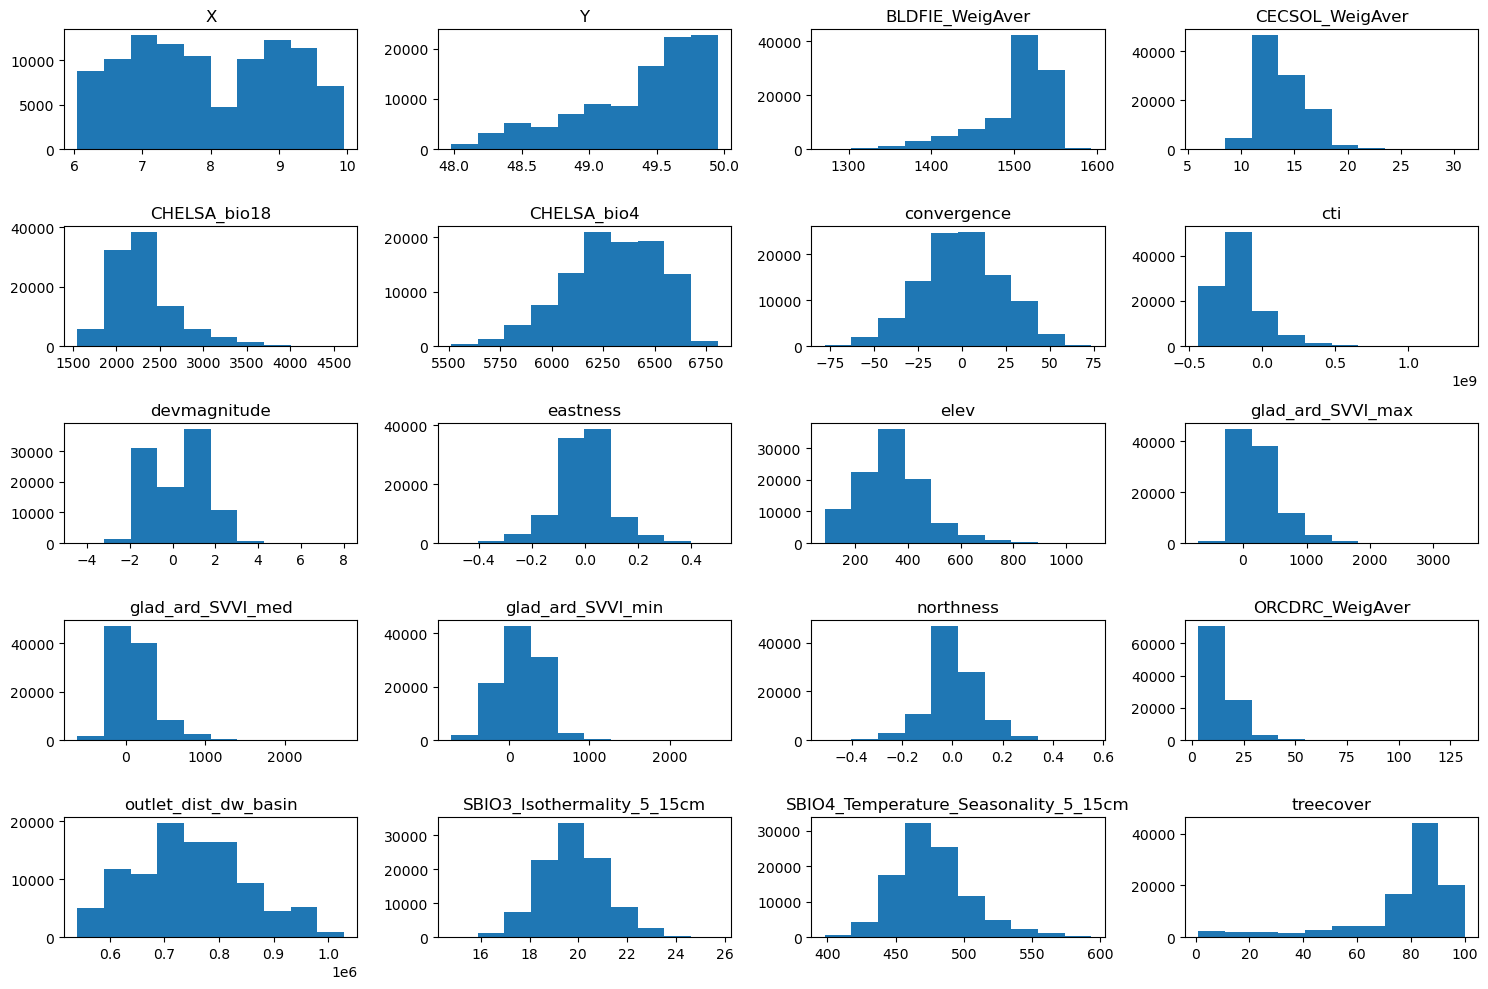

In [6]:
#Explore the raw data
n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
print('data.shape[1]: {}, n_plots_x: {},n_plots_y: {}'.format(data.shape[1],n_plots_x,n_plots_y))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data.shape[1]):
    ax[idx].hist(data.iloc[:, idx].to_numpy().flatten())
    ax[idx].set_title(data.columns[idx])
fig.tight_layout()

(array([2.100e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 6.000e+00, 1.200e+01, 3.900e+01, 9.500e+01, 1.440e+02,
        3.320e+02, 4.990e+02, 7.920e+02, 1.117e+03, 1.719e+03, 2.558e+03,
        3.423e+03, 4.343e+03, 5.174e+03, 6.243e+03, 7.178e+03, 7.680e+03,
        7.825e+03, 8.614e+03, 7.956e+03, 7.559e+03, 6.714e+03, 5.413e+03,
        4.225e+03, 3.138e+03, 2.510e+03, 1.653e+03, 1.313e+03, 7.550e+02,
        4.140e+02, 3.020e+02, 1.170e+02, 5.800e+01, 2.300e+01, 1.400e+01,
        1.200e+01, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.29265078, -2.20094474, -2.10923871, -2.01753268, -1.92582665,
        -1.83412062, -1.74241459, -1.65070856, -1.55900253, -1.4672965 ,
        -1.37559047, -1.28388443, -1.1921784 , -1.10047237, -1.00876634,
        -0.91706031, -0.82535428, -0.73364825, -0.64194222, -0.55023619,
        -0.45853016, -0.36682412, -0.27511809, -0.18341206, -0.09170603,
         0.

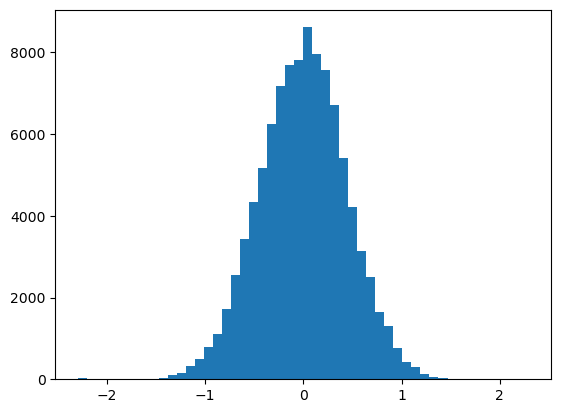

In [7]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
qt = QuantileTransformer(
    n_quantiles=500, output_distribution="normal", random_state=0
)

tree_height = qt.fit_transform(tree_height.reshape(-1,1))
scaler_tree = MinMaxScaler(feature_range=(-1,1))
tree_height = scaler_tree.fit_transform(tree_height).squeeze()
tree_height =tree_height/np.quantile(tree_height,0.99)
plt.hist(tree_height,50)

data.shape[1]: 20, n_plots_x: 5,n_plots_y: 4


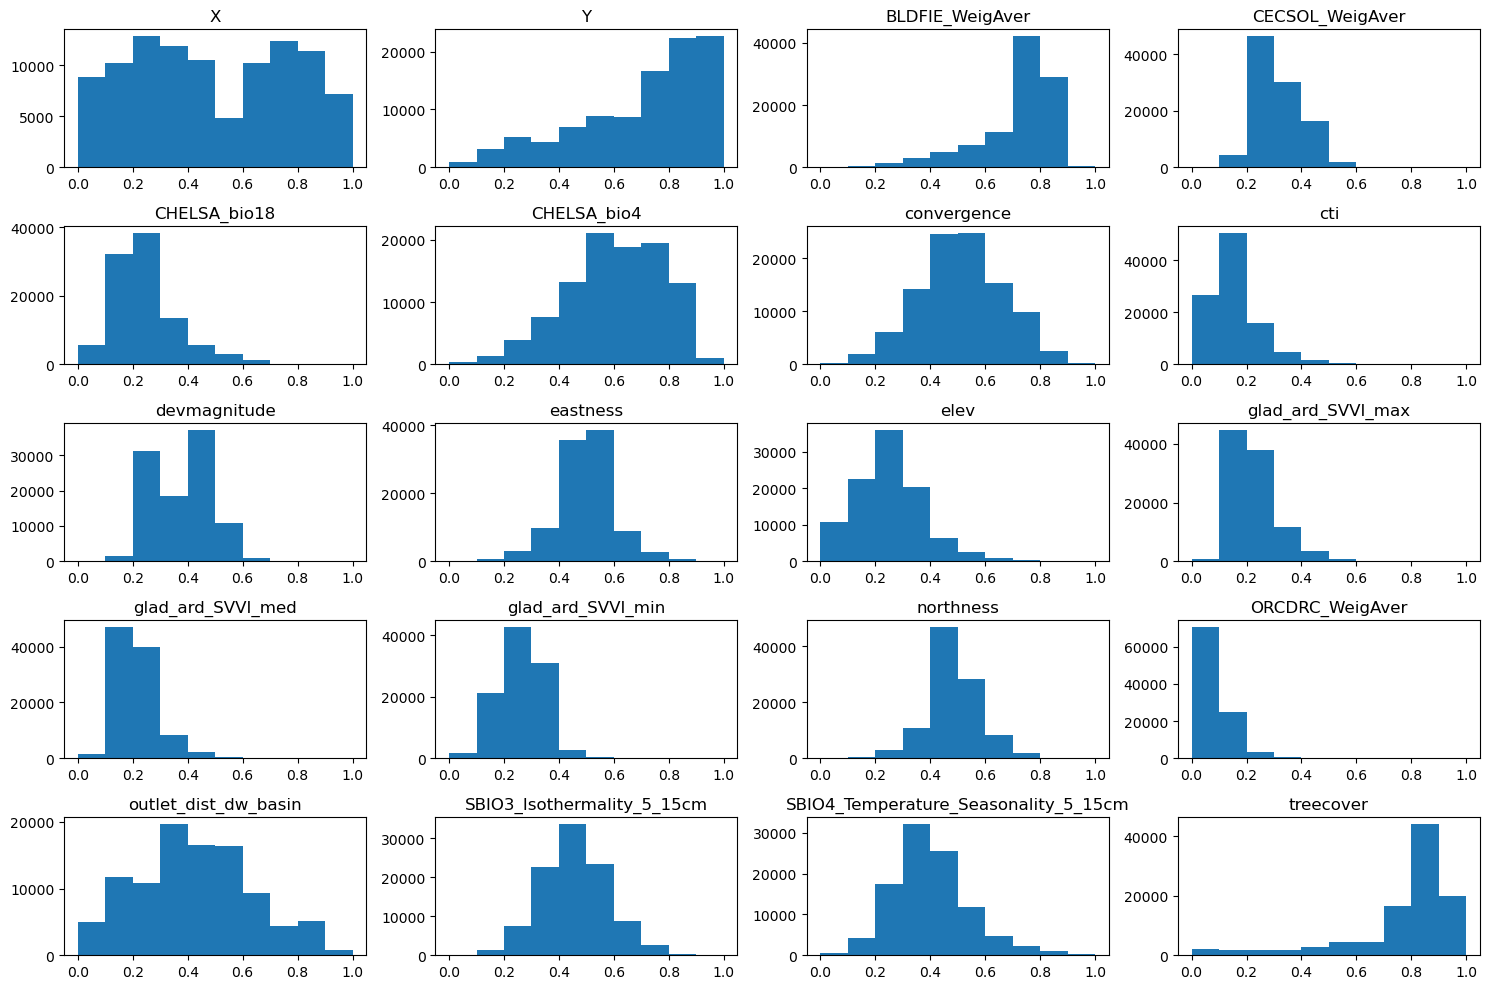

In [8]:
#Normalize the data
scaler_data = MinMaxScaler()
data_transformed = scaler_data.fit_transform(data)

n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
print('data.shape[1]: {}, n_plots_x: {},n_plots_y: {}'.format(data.shape[1],n_plots_x,n_plots_y))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data.shape[1]):
    ax[idx].hist(data_transformed[:,idx].flatten())
    ax[idx].set_title(data.columns[idx])
fig.tight_layout()

In [9]:
# Let's use all the data as one big minibatch

#Split the data
X_train, X_test, y_train, y_test = train_test_split(data_transformed,tree_height, test_size=0.30, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print('X_train.min: {}, X_test.min: {}, y_train.min: {}, y_test.min: {}'.format(X_train.min(), X_test.min(), y_train.min(), y_test.min()))
print('X_train.max: {}, X_test.max: {}, y_train.max: {}, y_test.max: {}'.format(X_train.max(), X_test.max(), y_train.max(), y_test.max()))

X_train.shape: torch.Size([70000, 20]), X_test.shape: torch.Size([30000, 20]), y_train.shape: torch.Size([70000]), y_test.shape: torch.Size([30000])
X_train.min: 0.0, X_test.min: 0.0, y_train.min: -2.2926506996154785, y_test.min: -2.2926506996154785
X_train.max: 1.0, X_test.max: 1.0, y_train.max: 1.6600875854492188, y_test.max: 2.2926506996154785


In [14]:
# Create the model
class Perceptron(torch.nn.Module):
    def __init__(self,input_size, output_size,use_activation_fn=None):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size,output_size)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.use_activation_fn=use_activation_fn
    def forward(self, x):
        output = self.fc(x)
        if self.use_activation_fn=='sigmoid':
            output = self.sigmoid(output) # To add the non-linearity. Try training you Perceptron with and without the non-linearity
        elif self.use_activation_fn=='tanh':
            output = self.tanh(output) 
        elif self.use_activation_fn=='relu':
            output = self.relu(output) 

        return output


hid_dim: 1, lr: 0.5
Epoch 0, train_loss: 0.2526, val_loss: 1.3197, r_value: 0.2170
Epoch 500, train_loss: nan, val_loss: nan, r_value: nan
Epoch 1000, train_loss: nan, val_loss: nan, r_value: nan
Epoch 1500, train_loss: nan, val_loss: nan, r_value: nan
Epoch 2000, train_loss: nan, val_loss: nan, r_value: nan
Epoch 2500, train_loss: nan, val_loss: nan, r_value: nan
Epoch 3000, train_loss: nan, val_loss: nan, r_value: nan
Epoch 3500, train_loss: nan, val_loss: nan, r_value: nan
Epoch 4000, train_loss: nan, val_loss: nan, r_value: nan
Epoch 4500, train_loss: nan, val_loss: nan, r_value: nan


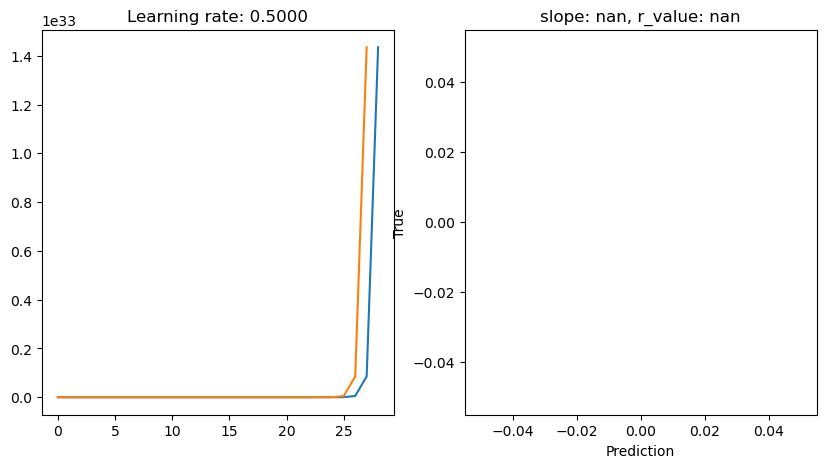


hid_dim: 1, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 1.0761, val_loss: 0.1856, r_value: 0.2688
Epoch 500, train_loss: 0.1569, val_loss: 0.1588, r_value: 0.4263
Epoch 1000, train_loss: 0.1562, val_loss: 0.1583, r_value: 0.4297
Epoch 1500, train_loss: 0.1559, val_loss: 0.1580, r_value: 0.4314
Epoch 2000, train_loss: 0.1557, val_loss: 0.1578, r_value: 0.4325
Epoch 2500, train_loss: 0.1556, val_loss: 0.1577, r_value: 0.4333
Epoch 3000, train_loss: 0.1555, val_loss: 0.1576, r_value: 0.4339
Epoch 3500, train_loss: 0.1554, val_loss: 0.1575, r_value: 0.4344
Epoch 4000, train_loss: 0.1553, val_loss: 0.1574, r_value: 0.4347
Epoch 4500, train_loss: 0.1553, val_loss: 0.1574, r_value: 0.4350


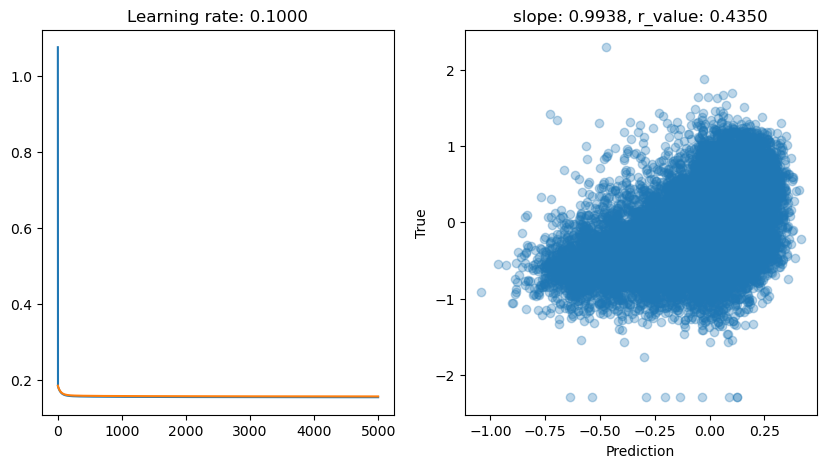


hid_dim: 1, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2121, val_loss: 0.2140, r_value: -0.2201
Epoch 500, train_loss: 0.1777, val_loss: 0.1793, r_value: 0.3114
Epoch 1000, train_loss: 0.1669, val_loss: 0.1686, r_value: 0.3794
Epoch 1500, train_loss: 0.1628, val_loss: 0.1647, r_value: 0.3954
Epoch 2000, train_loss: 0.1610, val_loss: 0.1629, r_value: 0.4032
Epoch 2500, train_loss: 0.1599, val_loss: 0.1619, r_value: 0.4081
Epoch 3000, train_loss: 0.1593, val_loss: 0.1613, r_value: 0.4116
Epoch 3500, train_loss: 0.1588, val_loss: 0.1608, r_value: 0.4143
Epoch 4000, train_loss: 0.1585, val_loss: 0.1605, r_value: 0.4164
Epoch 4500, train_loss: 0.1582, val_loss: 0.1602, r_value: 0.4181


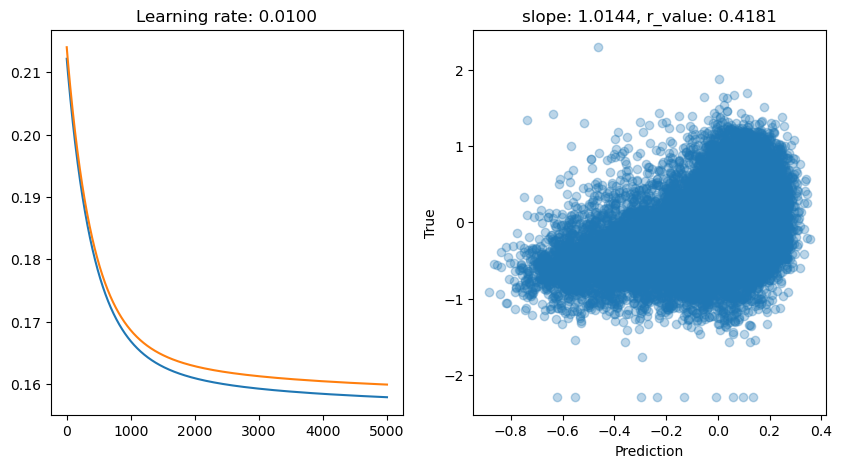


hid_dim: 1, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.2047, val_loss: 0.2045, r_value: 0.0191
Epoch 500, train_loss: 0.1586, val_loss: 0.1607, r_value: 0.4155
Epoch 1000, train_loss: 0.1571, val_loss: 0.1593, r_value: 0.4238
Epoch 1500, train_loss: 0.1566, val_loss: 0.1587, r_value: 0.4270
Epoch 2000, train_loss: 0.1563, val_loss: 0.1584, r_value: 0.4288
Epoch 2500, train_loss: 0.1561, val_loss: 0.1582, r_value: 0.4301
Epoch 3000, train_loss: 0.1560, val_loss: 0.1581, r_value: 0.4310
Epoch 3500, train_loss: 0.1558, val_loss: 0.1579, r_value: 0.4317
Epoch 4000, train_loss: 0.1557, val_loss: 0.1579, r_value: 0.4323
Epoch 4500, train_loss: 0.1557, val_loss: 0.1578, r_value: 0.4327


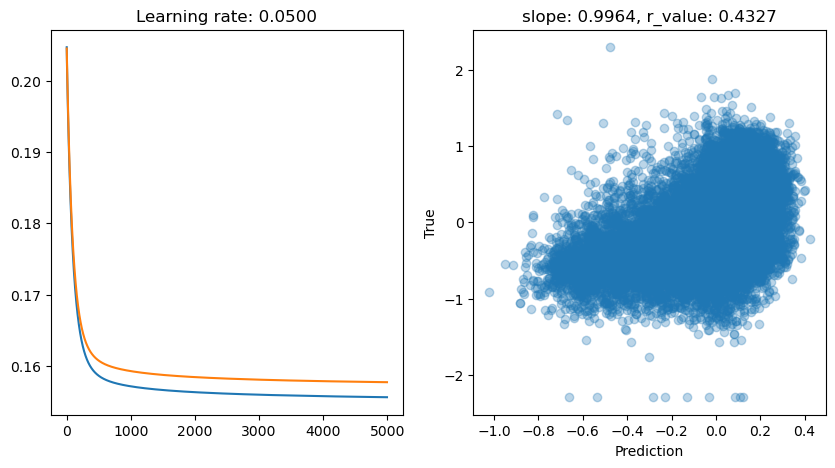


hid_dim: 1, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.2376, val_loss: 0.2398, r_value: 0.0721
Epoch 500, train_loss: 0.1872, val_loss: 0.1888, r_value: 0.1784
Epoch 1000, train_loss: 0.1843, val_loss: 0.1859, r_value: 0.2379
Epoch 1500, train_loss: 0.1817, val_loss: 0.1833, r_value: 0.2808
Epoch 2000, train_loss: 0.1794, val_loss: 0.1810, r_value: 0.3110
Epoch 2500, train_loss: 0.1774, val_loss: 0.1790, r_value: 0.3323
Epoch 3000, train_loss: 0.1756, val_loss: 0.1771, r_value: 0.3475
Epoch 3500, train_loss: 0.1740, val_loss: 0.1755, r_value: 0.3586
Epoch 4000, train_loss: 0.1725, val_loss: 0.1741, r_value: 0.3670
Epoch 4500, train_loss: 0.1713, val_loss: 0.1728, r_value: 0.3734


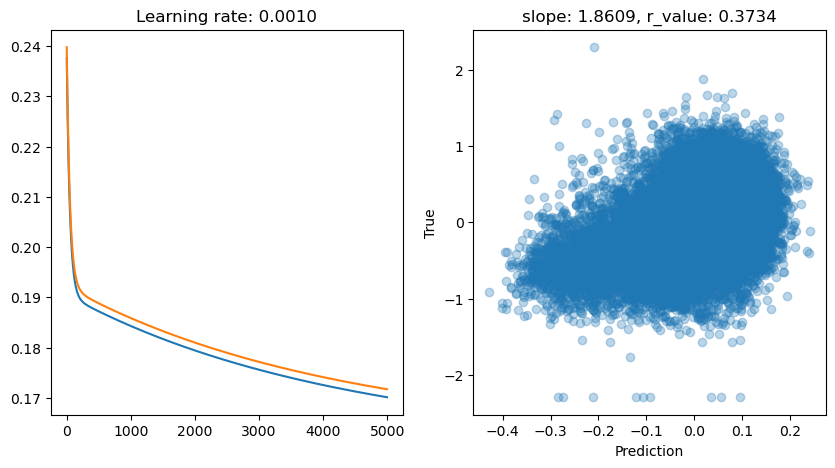

In [15]:
# model.train()
epoch = 5000
hid_dim_range = [1]#,256,512]
lr_range = [0.5,0.1,0.01,0.05,0.001]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Perceptron(data.shape[1], hid_dim)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test)
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test)
                all_loss_val.append(loss.item())
            
                if epoch%500==0:
                    y_pred = y_pred.detach().numpy().squeeze()
                    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(all_loss_train)
        ax[0].plot(all_loss_val)
        ax[0].set_title('Learning rate: {:.4f}'.format(lr))

        ax[1].scatter(y_pred, y_test, alpha=0.3)
        ax[1].set_xlabel('Prediction')
        ax[1].set_ylabel('True')
        ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()


hid_dim: 1, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.1765, val_loss: 0.1984, r_value: 0.3045
Epoch 500, train_loss: 0.6196, val_loss: 0.2610, r_value: 0.4032
Epoch 1000, train_loss: 0.6106, val_loss: 0.2654, r_value: 0.4084
Epoch 1500, train_loss: 0.6031, val_loss: 0.2706, r_value: 0.4097
Epoch 2000, train_loss: 0.5984, val_loss: 0.2739, r_value: 0.4105
Epoch 2500, train_loss: 0.5952, val_loss: 0.2760, r_value: 0.4111
Epoch 3000, train_loss: 0.5929, val_loss: 0.2776, r_value: 0.4115
Epoch 3500, train_loss: 0.5911, val_loss: 0.2788, r_value: 0.4119
Epoch 4000, train_loss: 0.5895, val_loss: 0.2799, r_value: 0.4121
Epoch 4500, train_loss: 0.5882, val_loss: 0.2808, r_value: 0.4122


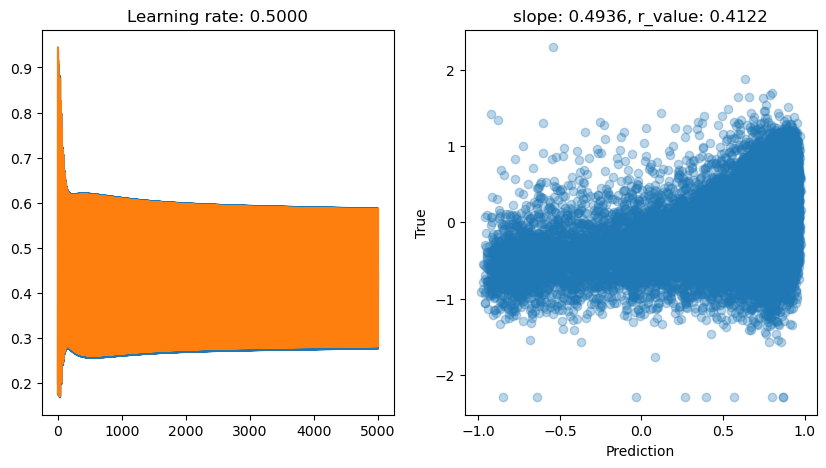


hid_dim: 1, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.2021, val_loss: 0.2027, r_value: 0.0360
Epoch 500, train_loss: 0.1571, val_loss: 0.1591, r_value: 0.4246
Epoch 1000, train_loss: 0.1561, val_loss: 0.1581, r_value: 0.4306
Epoch 1500, train_loss: 0.1556, val_loss: 0.1577, r_value: 0.4330
Epoch 2000, train_loss: 0.1554, val_loss: 0.1575, r_value: 0.4343
Epoch 2500, train_loss: 0.1552, val_loss: 0.1574, r_value: 0.4352
Epoch 3000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4359
Epoch 3500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 4000, train_loss: 0.1550, val_loss: 0.1571, r_value: 0.4367
Epoch 4500, train_loss: 0.1549, val_loss: 0.1570, r_value: 0.4371


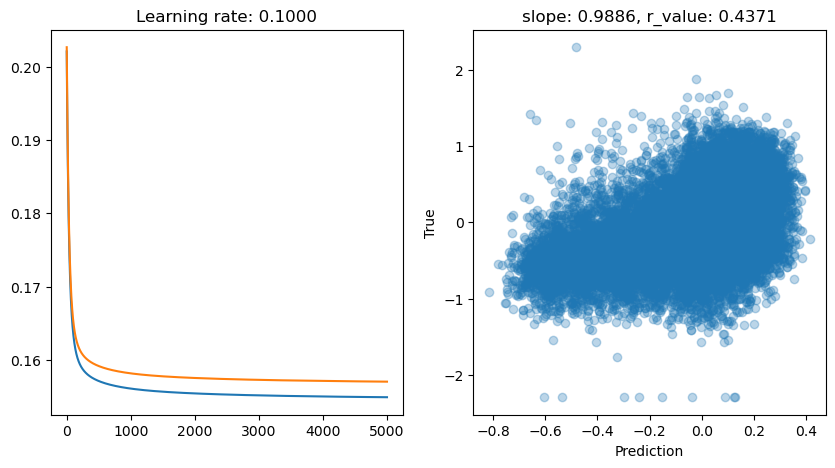


hid_dim: 1, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2339, val_loss: 0.2276, r_value: 0.0156
Epoch 500, train_loss: 0.1731, val_loss: 0.1748, r_value: 0.3445
Epoch 1000, train_loss: 0.1658, val_loss: 0.1676, r_value: 0.3817
Epoch 1500, train_loss: 0.1628, val_loss: 0.1647, r_value: 0.3943
Epoch 2000, train_loss: 0.1612, val_loss: 0.1631, r_value: 0.4015
Epoch 2500, train_loss: 0.1602, val_loss: 0.1622, r_value: 0.4064
Epoch 3000, train_loss: 0.1595, val_loss: 0.1615, r_value: 0.4101
Epoch 3500, train_loss: 0.1590, val_loss: 0.1610, r_value: 0.4130
Epoch 4000, train_loss: 0.1586, val_loss: 0.1606, r_value: 0.4154
Epoch 4500, train_loss: 0.1582, val_loss: 0.1603, r_value: 0.4173


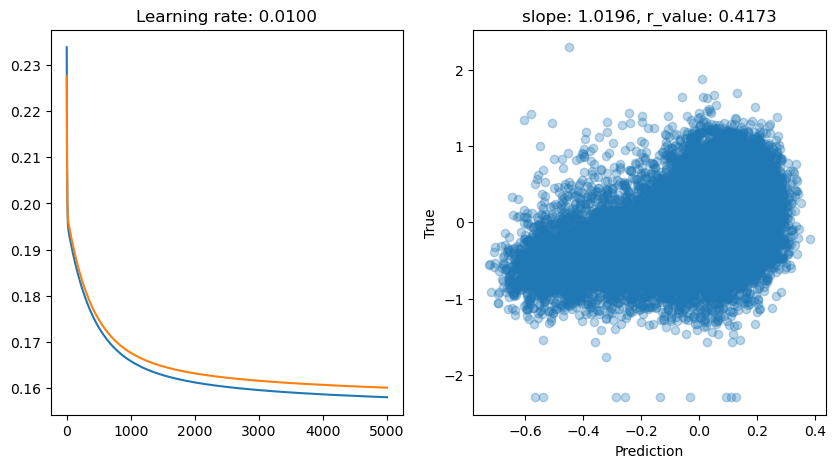


hid_dim: 1, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.2028, val_loss: 0.2019, r_value: -0.0755
Epoch 500, train_loss: 0.1585, val_loss: 0.1604, r_value: 0.4190
Epoch 1000, train_loss: 0.1570, val_loss: 0.1590, r_value: 0.4256
Epoch 1500, train_loss: 0.1564, val_loss: 0.1584, r_value: 0.4287
Epoch 2000, train_loss: 0.1561, val_loss: 0.1581, r_value: 0.4306
Epoch 2500, train_loss: 0.1559, val_loss: 0.1579, r_value: 0.4318
Epoch 3000, train_loss: 0.1557, val_loss: 0.1578, r_value: 0.4327
Epoch 3500, train_loss: 0.1556, val_loss: 0.1577, r_value: 0.4335
Epoch 4000, train_loss: 0.1555, val_loss: 0.1576, r_value: 0.4340
Epoch 4500, train_loss: 0.1554, val_loss: 0.1575, r_value: 0.4345


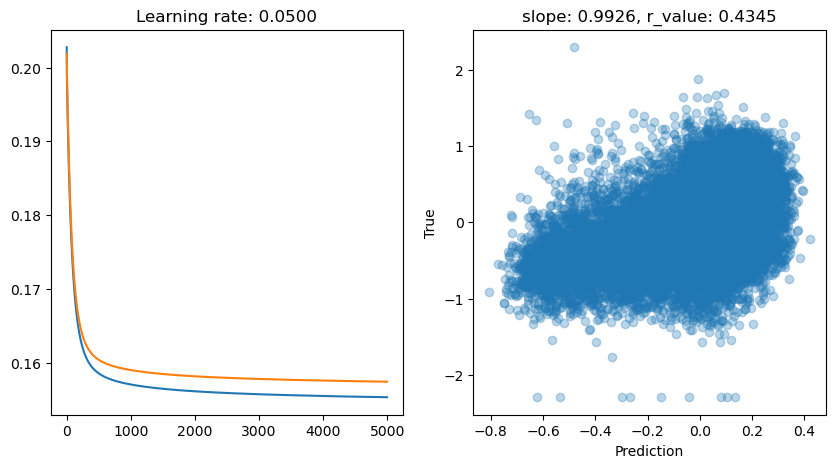


hid_dim: 1, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.2621, val_loss: 0.2638, r_value: -0.2578
Epoch 500, train_loss: 0.2152, val_loss: 0.2162, r_value: -0.2263
Epoch 1000, train_loss: 0.2094, val_loss: 0.2105, r_value: -0.1843
Epoch 1500, train_loss: 0.2042, val_loss: 0.2053, r_value: -0.1301
Epoch 2000, train_loss: 0.1995, val_loss: 0.2007, r_value: -0.0637
Epoch 2500, train_loss: 0.1954, val_loss: 0.1966, r_value: 0.0110
Epoch 3000, train_loss: 0.1916, val_loss: 0.1929, r_value: 0.0868
Epoch 3500, train_loss: 0.1883, val_loss: 0.1896, r_value: 0.1558
Epoch 4000, train_loss: 0.1854, val_loss: 0.1867, r_value: 0.2132
Epoch 4500, train_loss: 0.1827, val_loss: 0.1841, r_value: 0.2579


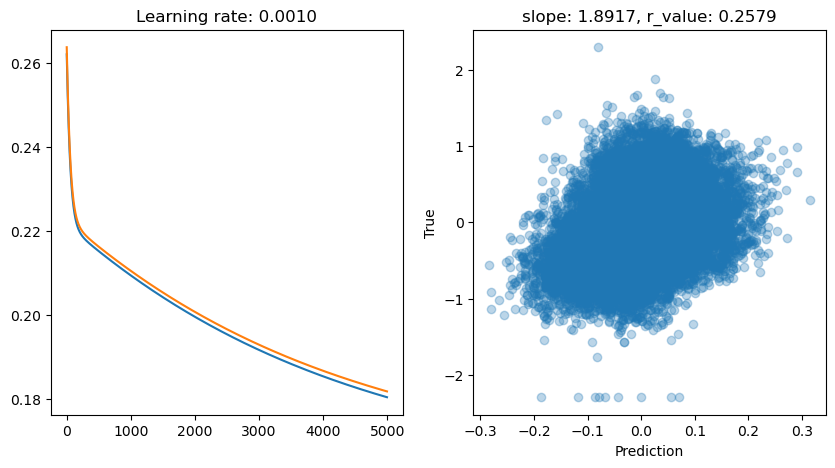

In [16]:
# model.train()
epoch = 5000
hid_dim_range = [1]#,256,512]
lr_range = [0.5,0.1,0.01,0.05,0.001]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Perceptron(data.shape[1], hid_dim, use_activation_fn='tanh')
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test)
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test)
                all_loss_val.append(loss.item())
            
                if epoch%500==0:
                    y_pred = y_pred.detach().numpy().squeeze()
                    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(all_loss_train)
        ax[0].plot(all_loss_val)
        ax[0].set_title('Learning rate: {:.4f}'.format(lr))

        ax[1].scatter(y_pred, y_test, alpha=0.3)
        ax[1].set_xlabel('Prediction')
        ax[1].set_ylabel('True')
        ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()

TanH works nicely. Would sigmoid or relu do well too? Try it!

We have tested SGD extensively. Now let's see what other optimizers have to offer (BACK TO SLIDES)


hid_dim: 1, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.2120, val_loss: 17.7507, r_value: 0.1192
Epoch 500, train_loss: 0.1551, val_loss: 0.1573, r_value: 0.4358
Epoch 1000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4363
Epoch 1500, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4364
Epoch 2000, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 2500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 3000, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 3500, train_loss: 0.1555, val_loss: 0.1582, r_value: 0.4364
Epoch 4000, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 4500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364


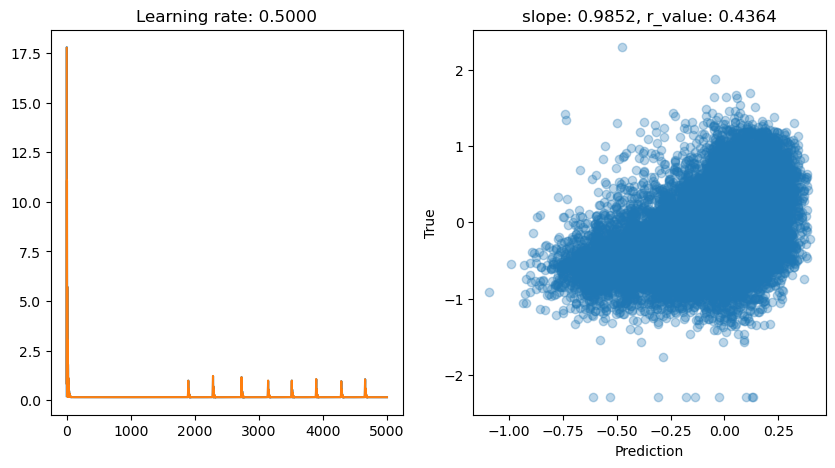


hid_dim: 1, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.2523, val_loss: 0.6905, r_value: -0.0343
Epoch 500, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4361
Epoch 1000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4364
Epoch 1500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 2000, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 2500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 3000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4364
Epoch 3500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 4000, train_loss: 0.1819, val_loss: 0.1950, r_value: 0.4354
Epoch 4500, train_loss: 0.1551, val_loss: 0.1576, r_value: 0.4364


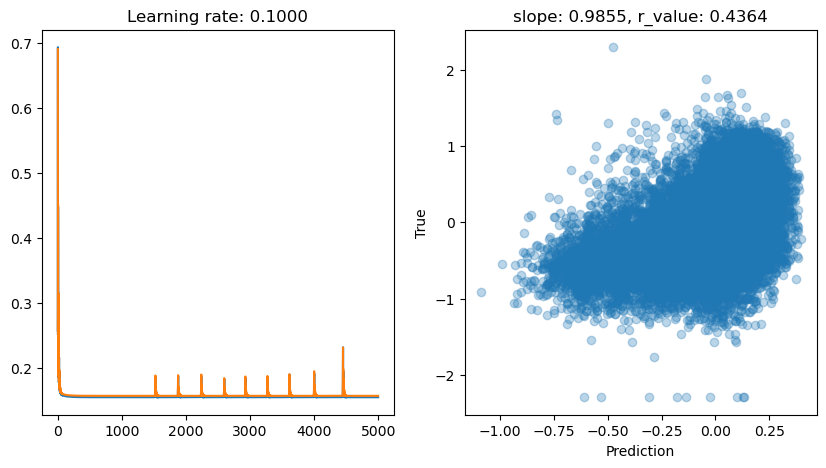


hid_dim: 1, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2188, val_loss: 0.1957, r_value: 0.1635
Epoch 500, train_loss: 0.1553, val_loss: 0.1574, r_value: 0.4349
Epoch 1000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4361
Epoch 1500, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4363
Epoch 2000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4364
Epoch 2500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 3000, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 3500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 4000, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 4500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364


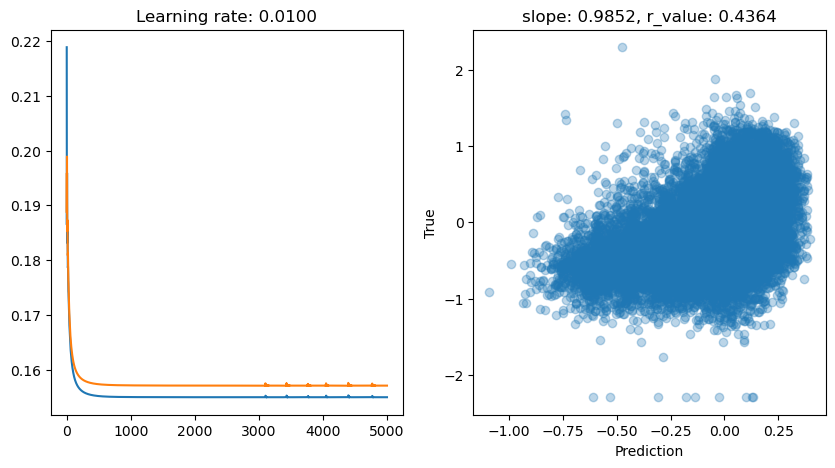


hid_dim: 1, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.3898, val_loss: 0.1955, r_value: 0.0314
Epoch 500, train_loss: 0.1552, val_loss: 0.1573, r_value: 0.4356
Epoch 1000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4362
Epoch 1500, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4364
Epoch 2000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4364
Epoch 2500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 3000, train_loss: 0.1557, val_loss: 0.1573, r_value: 0.4364
Epoch 3500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364
Epoch 4000, train_loss: 0.1551, val_loss: 0.1571, r_value: 0.4364
Epoch 4500, train_loss: 0.1550, val_loss: 0.1572, r_value: 0.4364


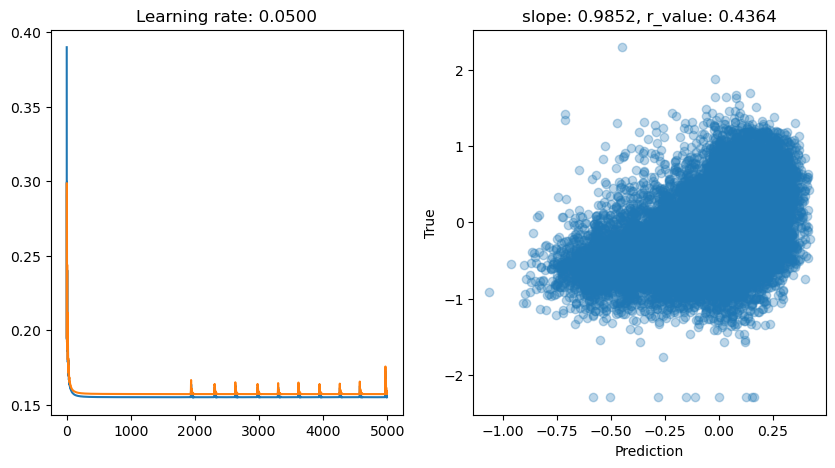


hid_dim: 1, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.2200, val_loss: 0.2175, r_value: 0.0194
Epoch 500, train_loss: 0.1618, val_loss: 0.1637, r_value: 0.4050
Epoch 1000, train_loss: 0.1568, val_loss: 0.1589, r_value: 0.4264
Epoch 1500, train_loss: 0.1558, val_loss: 0.1579, r_value: 0.4321
Epoch 2000, train_loss: 0.1554, val_loss: 0.1575, r_value: 0.4343
Epoch 2500, train_loss: 0.1552, val_loss: 0.1573, r_value: 0.4353
Epoch 3000, train_loss: 0.1551, val_loss: 0.1573, r_value: 0.4358
Epoch 3500, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4361
Epoch 4000, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4362
Epoch 4500, train_loss: 0.1551, val_loss: 0.1572, r_value: 0.4363


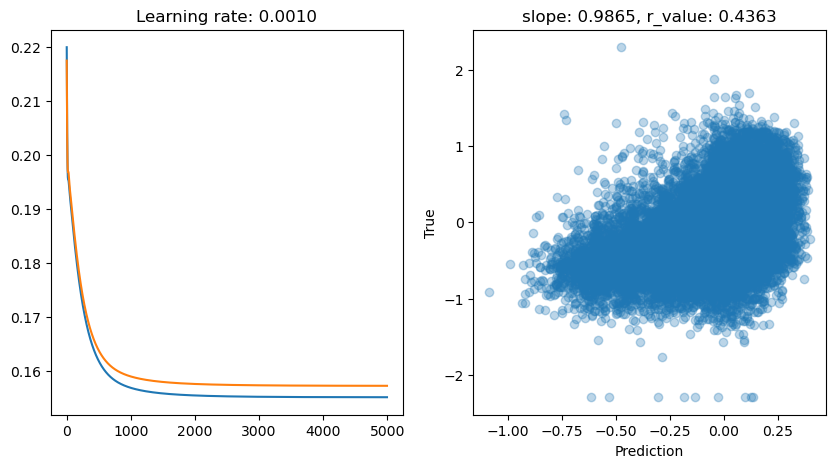

In [17]:
# Try ADAM optimizer
# model.train()
epoch = 5000
hid_dim_range = [1]#,256,512]
lr_range = [0.5,0.1,0.01,0.05,0.001]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Perceptron(data.shape[1], hid_dim)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        all_loss_train=[]
        all_loss_val=[]
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test)
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test)
                all_loss_val.append(loss.item())
            
                if epoch%500==0:
                    y_pred = y_pred.detach().numpy().squeeze()
                    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(all_loss_train)
        ax[0].plot(all_loss_val)
        ax[0].set_title('Learning rate: {:.4f}'.format(lr))

        ax[1].scatter(y_pred, y_test, alpha=0.3)
        ax[1].set_xlabel('Prediction')
        ax[1].set_ylabel('True')
        ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()

ADAM seems to be quite effective for training in this setup if compared to other tests we did. How is it performing compared to the SVR? How can we make it better?  